<a href="https://colab.research.google.com/github/arcweld/DSI_Capstone_2/blob/main/Capstone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Predictive Maintenance Project
This notebook explores a database created by NASA, the "Turbofan Engine Degradation Simulation Data Set", by appying a variety of machine learning models and developing an understanding of how such models could help in the predictive maintenance decision making process.

# Imports

In [35]:
import os
import zipfile
import urllib

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 12]
plt.style.use('ggplot')

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, balanced_accuracy_score
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split as tts
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
import itertools


# Modules and Helper Functions

### Data loading

In [36]:
DOWNLOAD_ROOT = 'https://ti.arc.nasa.gov/'
ENG_PATH = os.path.join('data','nasa_eng')
ENG_URL = DOWNLOAD_ROOT + 'c/6' 

def fetch_eng_data(eng_url=ENG_URL, eng_path=ENG_PATH):
    os.makedirs(eng_path, exist_ok=True)
    if not os.path.exists(os.path.join(eng_path,'CMAPSSData.zip')):
        zip_path = os.path.join(eng_path, 'CMAPSSData.zip')
        urllib.request.urlretrieve(eng_url, zip_path)
        eng_zip = zipfile.ZipFile(zip_path, 'r')
        eng_zip.extractall(path=eng_path)
        eng_zip.close()
        print('All files downloaded and extracted')
    else:
        print('All files in place')
        
    
def load_train_data(series_n=1):
    new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
    df = pd.read_csv(f'data/nasa_eng/train_FD00{series_n}.txt', sep=' ', names=new_col)
    df.drop(['x1', 'x2'], axis=1, inplace=True)
    return df

    
def load_test_data(series_n=1):
    new_col = ["id","cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21", 'x1', 'x2']
    df = pd.read_csv(f'data/nasa_eng/test_FD00{series_n}.txt', sep=' ', names=new_col, header=None)
    df.drop(['x1', 'x2'], axis=1, inplace=True)
    truth = pd.read_csv(f'data/nasa_eng/RUL_FD00{series_n}.txt', header=None, names=['eol'])
    truth['id'] = truth.index +1
    df = df.merge(truth, on=['id'], how='left')
    return df



### Data conditioning

In [37]:
def normalize_data(df1, *df2):
    scale = MinMaxScaler()
    scale.fit(df1.loc[:,'s1':'s21'])
    scale.transform(df1.loc[:,'s1':'s21'])
    if df2:
        scale.transform(df2.loc[:,'s1':'s21'])
        return df1, df2
    return df1

def add_labels(df):
    if 'eol' not in df.columns:
        fail = df.groupby('id').cycle.max()
        df['eol'] = df['id'].apply(lambda x: fail[x])

    df['RUL'] = df['eol'] - df['cycle']
    # df.drop('eol', axis=1, inplace=True)
    df['f30'] = df['RUL'].apply(lambda x: 2 if x <= 10 else 1 if x <=30 else 0)
    df['f10'] = df['RUL'].apply(lambda x: 1 if x <= 10 else 0)

    return df



### Test, train split

In [38]:
def tts(df0):
    df = df0.copy()

    n_eng = df['id'].unique()
    test_index = np.random.choice(n_eng, int(0.2*len(n_eng)))
    df_test = df[df['id'].isin(test_index)]
    df_test.sort_values(by =['id', 'cycle'])
    df_train = df[~df['id'].isin(test_index)]
    df_train.sort_values(by =['id', 'cycle'])

    return df_test, df_train 

def xy_split(df):
    X = df.drop(['RUL','f10','f30', 'eol'], axis=1)
    y_reg = df['RUL']
    y_clf = df['f10']
    y_mclf = df['f30']

    return X, y_reg, y_clf, y_mclf

### Windowing

In [39]:
def window_avg_sd(df0, win=10): 
    df = df0.copy()
    sensor = {f's{i}': [f'a{i}', f'sd{i}'] for i in range(1,22) }
    if 'a1' in df.columns: 
        print('DF previously transformed')
        return None
    for s, agg in sensor.items():
        for id in df.id.unique():
            avg = df[s].groupby(df['id']).rolling(window=win, min_periods=4).mean()
            sd = df[s].groupby(df['id']).rolling(window=win, min_periods=4).std()
        df.insert(len(df.columns), f'{agg[0]}', avg.values)
        df.insert(len(df.columns), f'{agg[1]}', sd.values)
    
    return df

def window_trending(df0, win=10):    
    df = df0.copy()
    sensor = {f's{i}': [f'a{i}', f'sd{i}', f'max{i}', f'min{i}', f'incr{i}', f'dec{i}'] for i in range(1,22) }
    if 'a1' in df.columns: 
        print('DF previously transformed')
        return None
    for s, agg in sensor.items():
        for id in df.id.unique():
            avg = df[s].groupby(df['id']).rolling(window=win, min_periods=4).mean()
            sd = df[s].groupby(df['id']).rolling(window=win, min_periods=4).std()
            max = df[s].groupby(df['id']).rolling(window=win, min_periods=4).max()
            min = df[s].groupby(df['id']).rolling(window=win, min_periods=4).min()
        df.insert(len(df.columns), f'{agg[0]}', avg.values)
        df.insert(len(df.columns), f'{agg[1]}', sd.values)
        df.insert(len(df.columns), f'{agg[2]}', max.values)
        df.insert(len(df.columns), f'{agg[3]}', min.values)

        df[agg[4]] = df[agg[0]] - df[agg[3]]
        df[agg[5]] = df[agg[2]] - df[agg[0]]

        df.dropna(inplace=True)

    return df


### Tensorflow

In [40]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]



# Load Data

In [41]:
fetch_eng_data()

All files in place


In [42]:
df1 = add_labels(load_train_data(1))
df_holdout = add_labels(load_test_data(1))


# Exploratory Data Analysis and Visualisation

## Visuals

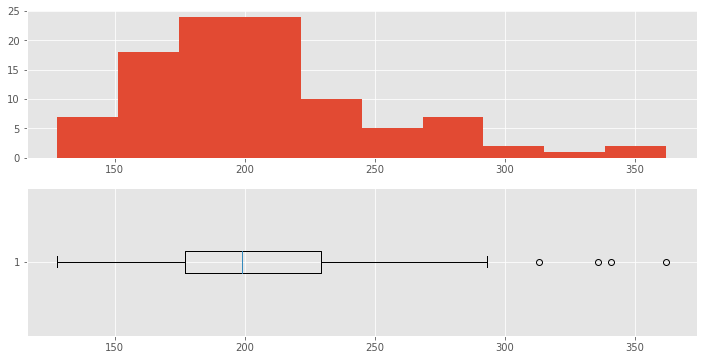

In [43]:
train1_fail = df1.groupby('id').cycle.max()

fig, axs = plt.subplots(2, figsize=(12,6))
axs[0].hist(train1_fail)
axs[1].boxplot(train1_fail, vert=False);

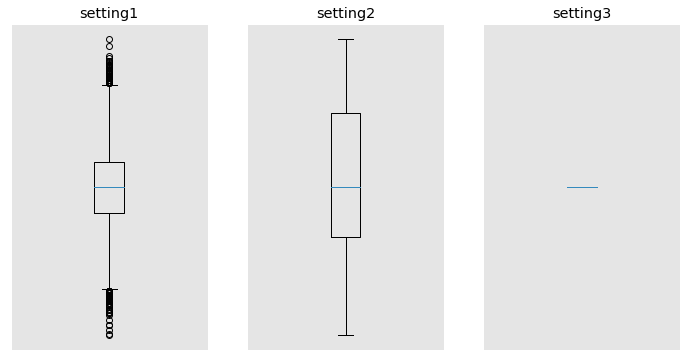

In [44]:
fig, axs = plt.subplots(1,3, figsize=(12,6))
for i in range(3):
    axs[i].boxplot(df1.iloc[:,i+2])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'setting{i+1}')
fig.savefig('data/boxplot_settings')

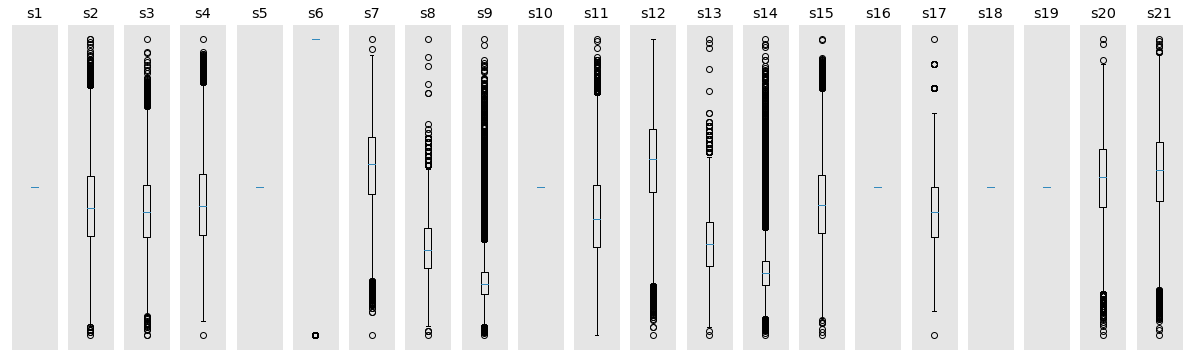

In [45]:
fig, axs = plt.subplots(1,21, figsize=(21,6))
for i in range(21):
    axs[i].boxplot(df1.iloc[:,i+5])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(label=f'{df1.columns[i+5]}')
plt.savefig('data/boxplot_sensors')

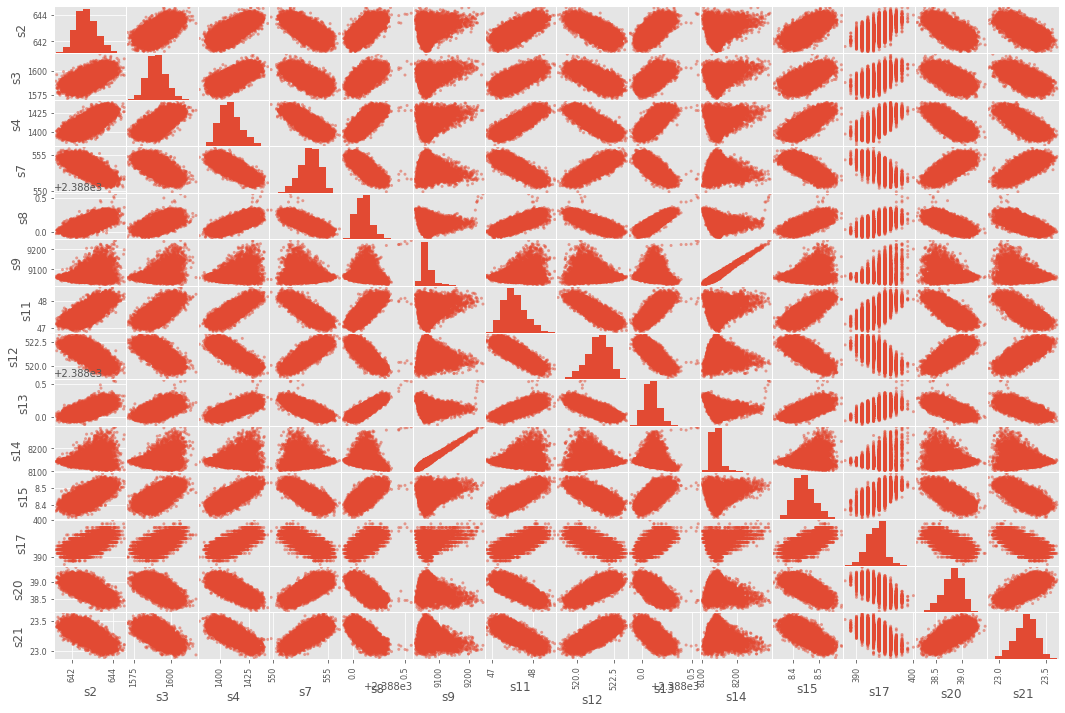

In [46]:
scatter_matrix(df1.iloc[:,np.r_[6,7,8,11,12,13,15,16,17,18,19,21,24,25]], figsize=(18,12));

In [47]:
q25 = pd.DataFrame(data=np.arange(51), columns=['RUL'])
q75 = pd.DataFrame(data=np.arange(51), columns=['RUL'])
sensor = [f's{i}' for i in range(1,22) ]
for s in sensor:
        q25.insert(len(q25.columns), f'{s}', df1[df1['RUL']<=50][s].groupby(df1['RUL']).quantile(0.25))
        q75.insert(len(q75.columns), f'{s}', df1[df1['RUL']<=50][s].groupby(df1['RUL']).quantile(0.75))
q25.set_index('RUL')

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
RUL,,,,,,,,,,,,,,,,,,,,,
0,518.67,643.5000,1599.2375,1428.0750,14.62,21.61,551.0150,2388.1800,9050.6175,1.3,48.0900,519.3950,2388.1975,8122.7500,8.513425,0.03,396.00,2388.0,100.0,38.3375,22.997975
1,518.67,643.4800,1599.0575,1426.1800,14.62,21.61,551.1375,2388.1900,9052.1825,1.3,48.1000,519.5275,2388.1875,8124.2450,8.511700,0.03,395.75,2388.0,100.0,38.3600,23.022775
2,518.67,643.4800,1599.7375,1426.0575,14.62,21.61,551.1750,2388.1800,9054.0100,1.3,48.0800,519.5075,2388.1900,8125.3375,8.510325,0.03,396.00,2388.0,100.0,38.3975,23.036975
3,518.67,643.3800,1598.8800,1426.0975,14.62,21.61,551.2575,2388.1700,9052.1325,1.3,48.0375,519.6025,2388.1800,8125.1350,8.509275,0.03,395.00,2388.0,100.0,38.3800,23.028725
4,518.67,643.4500,1600.3825,1424.1600,14.62,21.61,551.3300,2388.1600,9053.0225,1.3,48.0575,519.6625,2388.1700,8126.6875,8.503200,0.03,396.00,2388.0,100.0,38.4100,23.042500
5,518.67,643.3350,1597.8850,1424.7450,14.62,21.61,551.3175,2388.1700,9051.8475,1.3,48.0200,519.7075,2388.1600,8125.7825,8.500475,0.03,395.00,2388.0,100.0,38.4000,23.033050
6,518.67,643.3300,1598.0125,1423.1150,14.62,21.61,551.3975,2388.1575,9055.2200,1.3,48.0000,519.7700,2388.1500,8126.8700,8.497350,0.03,395.00,2388.0,100.0,38.4275,23.051100
7,518.67,643.3575,1597.4400,1422.4400,14.62,21.61,551.4200,2388.1675,9051.4100,1.3,47.9800,519.8350,2388.1675,8127.0300,8.493825,0.03,395.00,2388.0,100.0,38.4275,23.065925
8,518.67,643.3000,1597.8725,1422.7150,14.62,21.61,551.4875,2388.1500,9053.9675,1.3,47.9500,519.8175,2388.1600,8128.0800,8.492975,0.03,395.00,2388.0,100.0,38.4300,23.058400


In [48]:
eng_id3 = df1[df1['id'] == 3]
eng_id3.set_index('RUL')

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,eol,f30,f10
RUL,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
178,3,1,0.0008,0.0005,100.0,518.67,642.04,1584.20,1398.13,14.62,21.61,553.96,2388.06,9056.95,1.3,47.14,522.24,2388.00,8138.40,8.4207,0.03,391,2388,100.0,38.96,23.3205,179,0,0
177,3,2,-0.0010,0.0000,100.0,518.67,642.66,1587.04,1398.62,14.62,21.61,554.76,2388.05,9059.67,1.3,47.35,522.03,2388.01,8137.38,8.3949,0.03,390,2388,100.0,39.07,23.4369,179,0,0
176,3,3,0.0013,-0.0002,100.0,518.67,642.07,1580.75,1401.10,14.62,21.61,554.51,2388.03,9050.43,1.3,46.94,522.16,2388.01,8137.20,8.3820,0.03,393,2388,100.0,39.03,23.3162,179,0,0
175,3,4,0.0008,-0.0002,100.0,518.67,642.50,1580.12,1395.76,14.62,21.61,554.48,2388.07,9060.43,1.3,47.44,522.31,2388.07,8139.35,8.3940,0.03,391,2388,100.0,38.94,23.4901,179,0,0
174,3,5,0.0020,0.0004,100.0,518.67,641.97,1581.48,1394.05,14.62,21.61,554.14,2388.01,9054.36,1.3,47.16,522.00,2388.03,8135.99,8.4233,0.03,391,2388,100.0,38.90,23.4190,179,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,3,175,-0.0030,0.0004,100.0,518.67,643.15,1603.74,1424.17,14.62,21.61,551.47,2388.06,9172.76,1.3,48.12,520.34,2388.14,8238.86,8.5066,0.03,396,2388,100.0,38.49,22.9909,179,2,1
3,3,176,-0.0008,0.0002,100.0,518.67,643.93,1595.61,1438.51,14.62,21.61,551.93,2388.18,9185.88,1.3,47.98,520.91,2388.12,8251.82,8.5245,0.03,396,2388,100.0,38.49,23.0656,179,2,1
2,3,177,-0.0041,-0.0002,100.0,518.67,643.68,1601.21,1423.50,14.62,21.61,552.17,2388.13,9191.53,1.3,48.10,520.19,2388.16,8249.86,8.5286,0.03,397,2388,100.0,38.37,23.0336,179,2,1


In [49]:
eng_id3_50 = eng_id3[eng_id3['RUL'] <= eng_id3['RUL'].min() + 50]

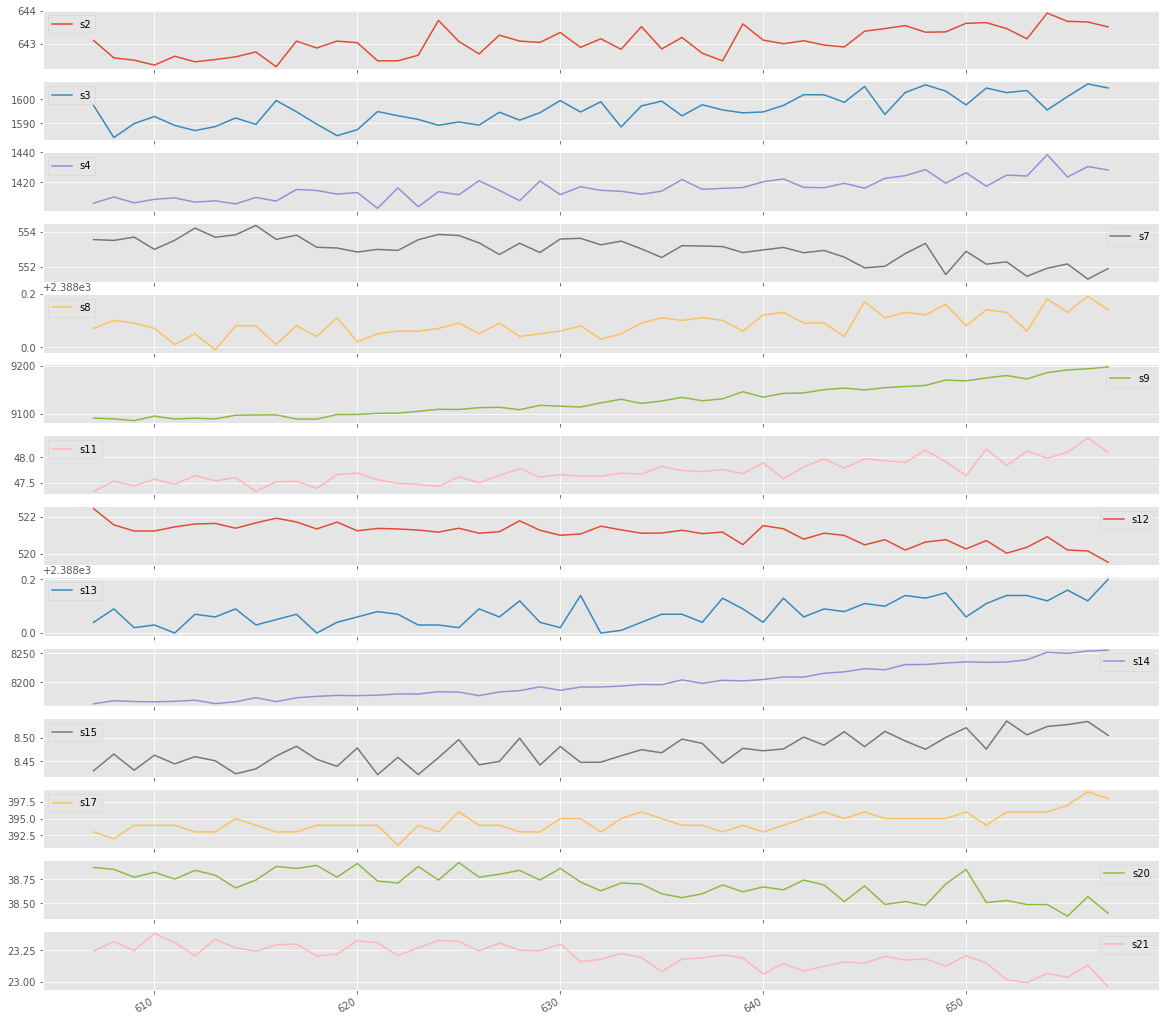

In [50]:
disp_cols = ['s2', 's3', 's4', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
cols1 = ['a2', 'a3', 'a4', 'a7', 'a8', 'a9', 'a11', 'a12', 'a13', 'a14', 'a15', 'a17', 'a20', 'a21']


# plotting sensor data for engine ID 3 prior to a failure point
eng_id3_50[disp_cols].plot(subplots=True, sharex=True, figsize=(20,20));



In [51]:
index = range(50,-1,-1)
anti_index = range(51)

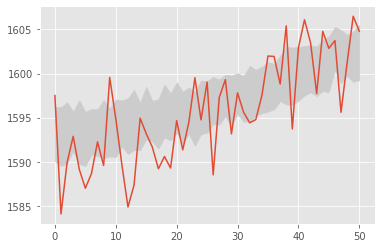

In [52]:
fig, ax = plt.subplots()
ax.plot(anti_index,eng_id3_50['s3'])
ax.fill_between(index, q25.s3.values.ravel(), q75.s3.values.ravel(), color='0.8')

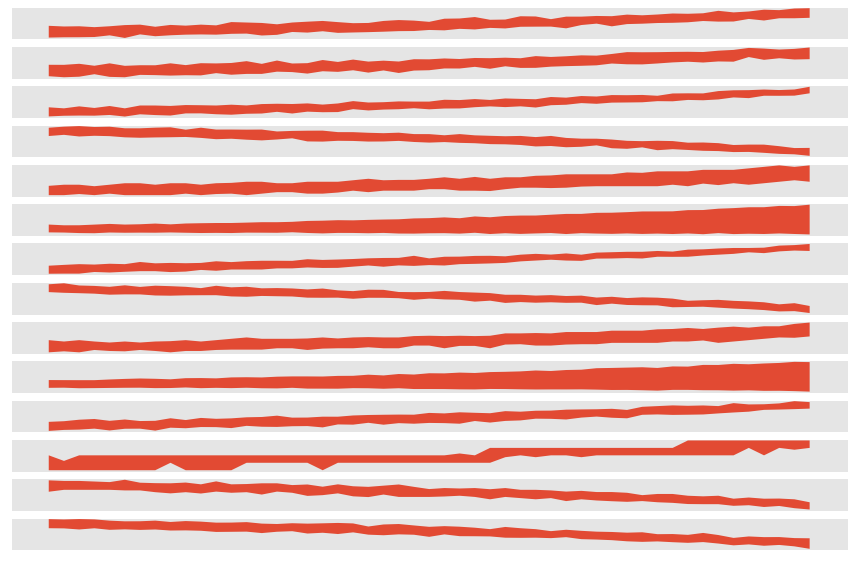

In [53]:
fig, ax = plt.subplots(len(disp_cols), figsize=(15,10))
for i, disp in enumerate(disp_cols):
  ax[i].fill_between(index, q25[disp].values.ravel(), q75[disp].values.ravel())
  # ax[i].plot(anti_index,eng_id3_50[disp], label=disp)
  ax[i].set_yticks([])
  ax[i].set_xticks([])
plt.savefig('data/trends')

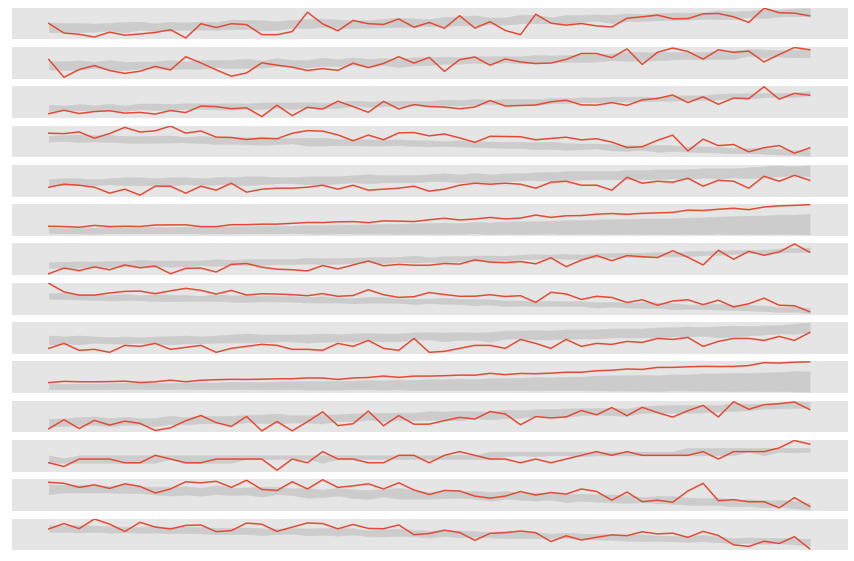

In [54]:
fig, ax = plt.subplots(len(disp_cols), figsize=(15,10))
for i, disp in enumerate(disp_cols):
  ax[i].fill_between(index, q25[disp].values.ravel(), q75[disp].values.ravel(), color='0.8')
  ax[i].plot(anti_index,eng_id3_50[disp], label=disp)
  ax[i].set_yticks([])
  ax[i].set_xticks([])
plt.savefig('data/compare_trends')

# Final cleaning of data

## Additional considered modifications of the data

`window_trending` adds columns to the dataframe, recording the average, standard deviation, increase and decrease over the previous rows for each sensor. 

In [55]:
df2 = window_trending(df1)

`window_avg_sd` is a simpler (earlier) version of `window_trending`, adding columns to the dataframe recording the average and standard deviation over the previous rows for each sensor. 

In [56]:
# df3 = window_avg_sd(df1)

## Train/Test Split

In [58]:
df_train, df_test = tts(df1)
X, y_reg, y_clf, y_mclf = xy_split(df_train)
X_test, y_test_reg, y_test_clf, y_test_mclf = xy_split(df_test)

# Build models

## Linear Regression

In [59]:
reg = LinearRegression()

reg.fit(X, y_reg)
reg.score(X, y_reg)

0.708309704651883

In [60]:
print(f'MSE: {mean_squared_error(y_reg, reg.predict(X))}')

MSE: 1234.6475971600285


In [61]:
reg.score(X_test, y_test_reg)

0.5776286765893772

## OLS with StatsModel

In [62]:
model = sm.OLS(y_reg, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    RUL   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     467.8
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:21:47   Log-Likelihood:                -18320.
No. Observations:                3680   AIC:                         3.668e+04
Df Residuals:                    3660   BIC:                         3.680e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
id            -0.0021      0.022     -0.095      0.9

## Logistics Regression

In [63]:
log = LogisticRegression(max_iter=10**6)

log.fit(X, y_clf)
y_pred = log.predict(X)
log.score(X, y_clf)
confusion_matrix(y_pred, y_clf)

array([[3448,   38],
       [  34,  160]])

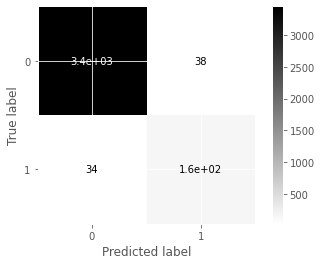

In [64]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_clf), display_labels=log.classes_)
disp.plot(cmap='binary');

In [65]:
print(f'F1 score: {f1_score(y_clf, y_pred)}')
print(f'accuracy: {accuracy_score(y_clf, y_pred)}')
print(f'recall: {recall_score(y_clf, y_pred)}')
print(f'precision: {precision_score(y_clf, y_pred)}')

F1 score: 0.8163265306122448
accuracy: 0.9804347826086957
recall: 0.8080808080808081
precision: 0.8247422680412371


In [66]:
balanced_accuracy_score(y_clf, y_pred)

0.8991581524608521

## Random Forest classifier

In [67]:
clf = RandomForestClassifier()
clf.fit(X,y_mclf)
clf.score(X,y_mclf)

1.0

In [68]:
y_pred = clf.predict(X)

In [69]:
cm = confusion_matrix(y_pred, y_mclf)
cm

array([[3122,    0,    0],
       [   0,  360,    0],
       [   0,    0,  198]])

In [70]:
t0, f01, f02, f10, t1, f12, f20, f21, t2 = cm.ravel()
# print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')

In [71]:
clf.score(X_test,y_test_mclf)

0.9397085717656776

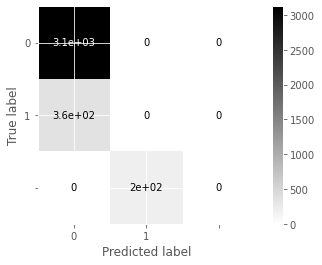

In [72]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_clf), display_labels=log.classes_)
disp.plot(cmap='binary');

In [73]:
y_pred = clf.predict(X_test)
y_pred.reshape(1,-1)

array([[0, 0, 0, ..., 2, 2, 2]], dtype=int64)

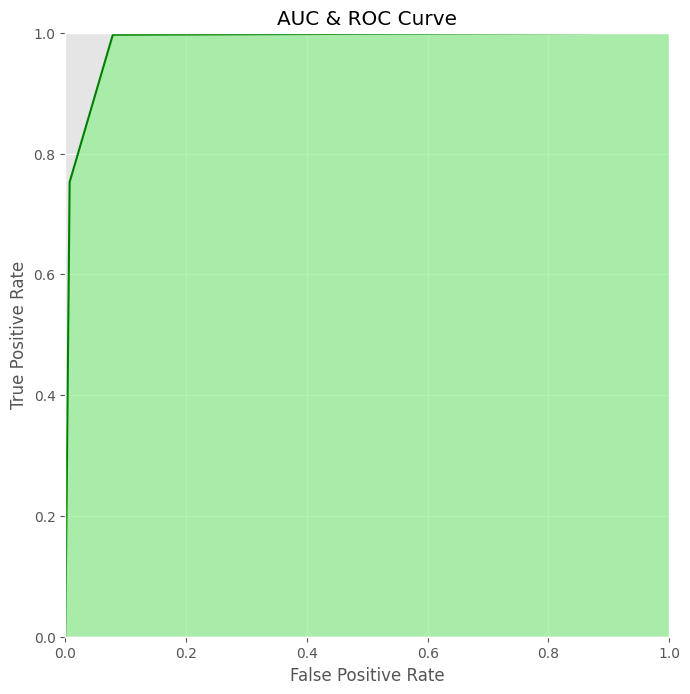

In [74]:
false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test_clf, y_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [75]:
# tn, fp, fn, tp = cm.ravel()
# print(f'F1 score: {2 * tp / (2* tp + fp +fn)}')
# print(f'accuracy: { (tp + tn) / (tp +fn + fp + tn)}')
# print(f'recall: { tp / (tp + fn)}')
# print(f'precision: { tp / (tp + fp)}')

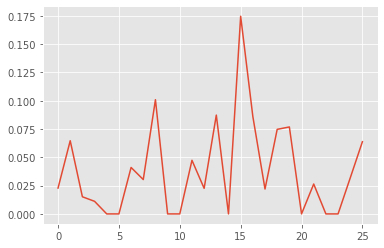

In [76]:
plt.plot(clf.feature_importances_)

### Random Forest Classifier - CV

In [77]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum depth
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [78]:
rfc = RandomForestClassifier()

rf_mclf = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, 
                             n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_mclf.fit(X,y_mclf)
rf_mclf.score(X,y_mclf)

rf_mclf.fit(X,y_mclf)
rf_mclf.score(X,y_mclf)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.8min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 22.8min finished


1.0

In [83]:
rf_mclf.best_params_

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1600}

In [79]:
y_pred = rf_mclf.predict(X)

cm = confusion_matrix(y_pred, y_mclf)

0.9378797711049496

array([[3122,    0,    0],
       [   0,  360,    0],
       [   0,    0,  198]])

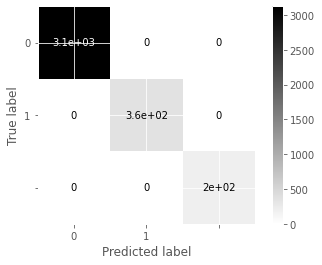

In [80]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_pred, y_mclf, normalize=‘all’), display_labels=log.classes_)
disp.plot(cmap='binary');
cm

In [ ]:
rf_mclf.score(X_test,y_test_mclf)

In [81]:
y_test_pred = rf_mclf.predict(X_test)
y_pred.reshape(1,-1)

array([[0, 0, 0, ..., 2, 2, 2]], dtype=int64)

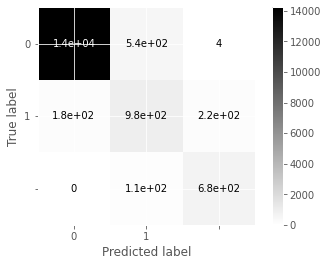

In [82]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_pred, y_test_mclf, normalize=‘all’), display_labels=log.classes_)
disp.plot(cmap='binary'); 

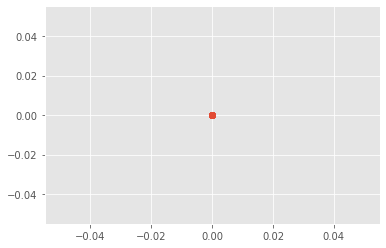

In [84]:
plt.scatter(y_mclf[X['cycle']==100], y_pred[X['cycle']==100])

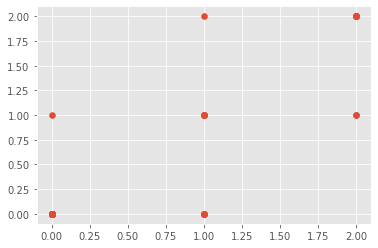

In [85]:
plt.scatter(y_test_mclf[X_test['cycle']==150], y_test_pred[X_test['cycle']==150])

## Random Forest Regressor

In [86]:
df_train, df_test = tts(df2[['id','cycle', 'setting1', 'setting2', 'a1', 'incr1', 'dec1', 
                             'a2', 'incr2', 'dec2', 'a3', 'incr3', 'dec3', 'a4', 'incr4', 'dec4', 
                             'a5', 'incr5', 'dec5', 'a6', 'incr6', 'dec6', 'a7', 'incr7', 'dec7', 
                             'a8', 'incr8', 'dec8', 'a9', 'incr9', 'dec9', 'a10', 'incr10', 'dec10',
                             'a11', 'incr11', 'dec11', 'a12', 'incr12', 'dec12', 'a13', 'incr13', 'dec13',
                             'a14', 'incr14', 'dec14', 'a15', 'incr15', 'dec15', 'a16', 'incr16', 'dec16', 
                             'a17', 'incr17', 'dec17', 'a18','incr18', 'dec18', 'a19', 'incr19', 'dec19', 
                             'a20',  'incr20', 'dec20', 'a21', 'incr21', 'dec21', 'RUL', 'f10', 'f30', 'eol']])
X, y_reg, y_clf, y_mclf = xy_split(df_train)
X_test, y_test_reg, y_test_clf, y_test_mclf = xy_split(df_test)

In [87]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum depth
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [88]:
clf_reg = RandomForestRegressor(oob_score=True, verbose=1)
rf_reg = RandomizedSearchCV(estimator = clf_reg, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_reg.fit(X,y_reg)
rf_reg.score(X,y_reg)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 33.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.6s finished


0.9968365184093041

In [89]:
rf_reg.best_params_ 

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [90]:
y_pred = rf_reg.predict(X)
y_test_pred = rf_reg.predict(X_test)
rf_reg.score(X_test,y_test_reg)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    2.2s finished


0.6442418856868564

In [91]:
np.sum(y_pred - y_reg.values) / len(y_pred - y_reg.values)

0.0013058618608734278

In [92]:
len(y_pred)

2170

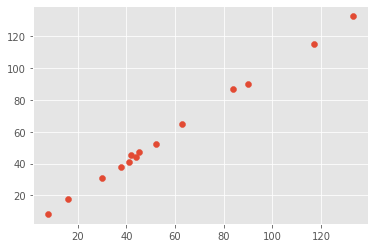

In [93]:
plt.scatter(y_reg[X['cycle']==150], y_pred[X['cycle']==150])

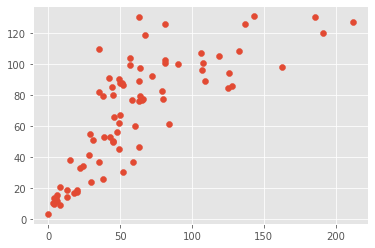

In [94]:
plt.scatter(y_test_reg[X_test['cycle']==150], y_test_pred[X_test['cycle']==150])

## Gradient Boosting Model



### Binary Classification with lightGBM

In [ ]:
lgb = LGBMClassifier(random_state=0, metric='auc')
lgb.fit(X, y_clf)
lgb.score(X, y_clf)

In [ ]:
y_pred = lgb.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test_clf, y_pred)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test_clf, y_pred)

plt.figure(figsize=(6, 6), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

### Regressor with sklearn

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X, y_reg)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred = gbr.predict(X)
gbr.score(X, y_reg)

0.9865793637298564

In [ ]:
gbr.predict(X_test)
gbr.score(X_test, y_test_reg)

0.5900809467986812

In [ ]:
gbr.feature_importances_

array([2.51853917e-01, 6.10220762e-01, 9.72968535e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.03401892e-03, 8.16589971e-04,
       4.14757441e-02, 0.00000000e+00, 2.18324972e-04, 3.42390638e-03,
       6.99971049e-04, 4.22898140e-03, 0.00000000e+00, 4.69570815e-02,
       8.19630015e-03, 2.72072491e-03, 5.40887679e-03, 9.96219741e-03,
       0.00000000e+00, 4.45120878e-03, 0.00000000e+00, 0.00000000e+00,
       4.38888630e-03, 3.84521184e-03])

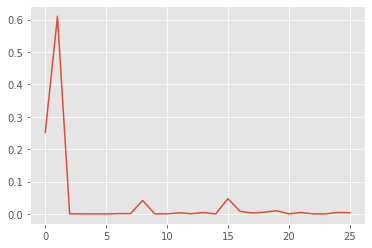

In [ ]:
plt.plot(gbr.feature_importances_)

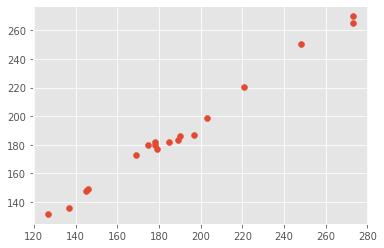

In [ ]:
plt.scatter(y_reg[X['cycle']==10], y_pred[X['cycle']==10])

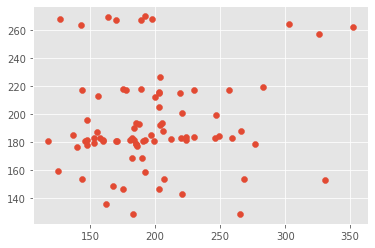

In [ ]:
plt.scatter(y_test_reg[X_test['cycle']==10], gbr.predict(X_test)[X_test['cycle']==10])

## Neural Networks with TensorFlow (LSTM) as Classifier

In [ ]:
# MODELLING.....pick a large window size of 50 cycles
seq_length = 3

In [ ]:
seq_cols = ["cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

#### Generate sequences

In [ ]:
# generator for the sequences
seq_gen = (list(gen_sequence(df1[df1['id']==id], seq_length, seq_cols)) 
           for id in df1['id'].unique())

In [ ]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

#### Generate labels

In [ ]:
# generate labels
label_gen = [gen_labels(df1[df1['id']==id], seq_length, ['f10']) 
             for id in df1['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

#### Define LSTM network

In [ ]:
# Define the LSTM network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm_c = Sequential()

lstm_c.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=False))
# lstm_c.add(Dropout(0.2))

# lstm_c.add(LSTM(
#           units=50,
#           return_sequences=False))
# lstm_c.add(Dropout(0.2))

lstm_c.add(Dense(units=nb_out, activation='sigmoid'))
lstm_c.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])

print(lstm_c.summary())

#### Train model

In [ ]:
# Train the network
lstm_c.fit(seq_array, label_array, epochs=30, batch_size=200, validation_split=0.10, verbose=1,
          callbacks = [callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')])

# training metrics
scores = lstm_c.evaluate(seq_array, label_array, verbose=1, batch_size=200)
scores

#### Make predictions

In [ ]:
# make predictions and compute confusion matrix
y_pred = lstm_c.predict(seq_array) 

In [ ]:
y_true = label_array
y_true.ravel()

In [ ]:
cm = confusion_matrix(y_true, y_pred, normalize=‘all’)
tn, fp, fn, tp = cm.ravel()
print(f'tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}')

#### Confusion Matrix

In [ ]:
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot();


#### Performance measures

In [ ]:
print(f'F1 score: {2 * tp / (2* tp + fp +fn)}')
print(f'accuracy: { (tp + tn) / (tp +fn + fp + tn)}')
print(f'recall: { tp / (tp + fn)}')
print(f'precision: { tp / (tp + fp)}')

In [ ]:

# compute AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true, y_pred)
print( f'auc = {auc}')

#### Data Checking and Fault Isolation

In [ ]:
len(next(seq_gen))

In [ ]:
eng_id3.shape

In [ ]:
eng = gen_sequence(eng_id3, 5, ["s1","s2","s3","s4","s5","s6"])

In [ ]:
next(eng)

In [ ]:
df1.id.value_counts().sort_values()

In [ ]:
df1[df1['id']==99]

In [ ]:
eng99 = gen_sequence(df1[df1['id']==99], 50, ['cycle',"s1","s2","s3","s4","s5","s6"])
next(eng99)

In [ ]:
label_array[130:200,:]

In [ ]:
np.sum(label_array)

In [ ]:
seq_array[0].shape

In [ ]:
seq_length

In [ ]:
len(y_pred)

In [ ]:
np.sum(y_pred)

## Neural Networks with TensorFlow (LSTM) as Regressor

#### Prepare model inputs

In [ ]:
# MODELLING.....pick a large window size of 50 cycles
seq_length = 3
seq_cols = ["cycle","setting1","setting2","setting3","s1","s2","s3","s4","s5","s6","s7","s8","s9","s10","s11","s12","s13","s14","s15","s16","s17","s18","s19","s20","s21"]

# generator for the sequences
seq_gen = (list(gen_sequence(df1[df1['id']==id], seq_length, seq_cols)) 
           for id in df1['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

# generate labels
label_gen = [gen_labels(df1[df1['id']==id], seq_length, ['RUL']) 
             for id in df1['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape



#### Define model

In [ ]:
# Define the LSTM network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

lstm = Sequential()

lstm.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=100,
         return_sequences=False))
# lstm.add(Dropout(0.2))

# lstm.add(LSTM(
#           units=50,
#           return_sequences=False))
# lstm.add(Dropout(0.2))

lstm.add(Dense(units=1, activation='linear'))
lstm.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True), metrics=['mse'])

print(lstm.summary())

#### Train model

In [ ]:
# Train the network
lstm.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.10, verbose=1,
          callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=100, min_delta=0, verbose=1, mode='auto')])
          # , callbacks.ReduceLROnPlateau()

# training metrics
scores = lstm.evaluate(seq_array, label_array, verbose=1, batch_size=200)
scores

#### Make predictions

In [ ]:
# make predictions 
y_pred = lstm.predict(seq_array) 
y_pred.shape

In [ ]:
y_pred

## 

## Quicklooks

### df1

In [ ]:
df1.head()
df1.describe()
df1.info()
df1.eol.unique()
df1.eol.max(), df1.eol.min()

### df2

In [ ]:
df2.head()
df2.columns[0:5]
df2.columns[5:26]
df2.columns[26:30]
df2.columns[30:84]
df2.columns[84:]

df2.info()

### df_train

In [95]:
df_train.head()

,id,cycle,setting1,setting2,a1,incr1,dec1,a2,incr2,dec2,a3,incr3,dec3,a4,incr4,dec4,a5,incr5,dec5,a6,incr6,dec6,a7,incr7,dec7,a8,incr8,dec8,a9,incr9,dec9,a10,incr10,dec10,a11,incr11,dec11,a12,incr12,dec12,a13,incr13,dec13,a14,incr14,dec14,a15,incr15,dec15,a16,incr16,dec16,a17,incr17,dec17,a18,incr18,dec18,a19,incr19,dec19,a20,incr20,dec20,a21,incr21,dec21,RUL,f10,f30,eol
2199,11,64,0.0002,-0.0003,518.67,0.0,0.0,642.125,0.335,0.575,1586.191,4.421,9.259,1399.324,7.814,5.976,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.521,0.691,0.779,2388.015,0.055,0.055,9053.965,3.785,8.235,1.3,2.220446e-16,-2.220446e-16,47.265,0.175,0.105,522.158,0.238,0.262,2388.016,0.036,0.044,8139.353,4.683,4.577,8.39853,0.01883,0.02707,0.03,6.938894e-18,-6.938894e-18,391.8,0.8,1.2,2388.0,0.0,0.0,100.0,0.0,0.0,38.992857,0.162857,0.097143,23.389075,0.127775,0.115825,176,0,0,240
2200,11,65,-0.0008,0.0004,518.67,0.0,0.0,642.157,0.367,0.543,1586.226,4.456,9.224,1400.019,6.859,5.281,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.528,0.698,0.772,2388.015,0.055,0.055,9053.952,3.772,8.248,1.3,2.220446e-16,-2.220446e-16,47.272,0.182,0.098,522.203,0.283,0.217,2388.018,0.038,0.042,8139.307,4.637,4.623,8.39756,0.01786,0.02804,0.03,6.938894e-18,-6.938894e-18,391.7,0.7,1.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.967500,0.177500,0.122500,23.380320,0.119020,0.124580,175,0,0,240
2201,11,66,0.0031,0.0002,518.67,0.0,0.0,642.159,0.369,0.561,1586.625,4.855,8.825,1399.741,6.581,5.559,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.537,0.707,0.763,2388.015,0.055,0.055,9054.965,4.185,7.235,1.3,2.220446e-16,-2.220446e-16,47.264,0.174,0.106,522.225,0.205,0.195,2388.010,0.030,0.040,8139.833,2.263,4.097,8.39775,0.01615,0.02785,0.03,6.938894e-18,-6.938894e-18,391.7,0.7,1.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.984444,0.194444,0.135556,23.385817,0.124517,0.119083,174,0,0,240
2202,11,67,-0.0001,0.0002,518.67,0.0,0.0,642.181,0.391,0.539,1586.669,4.899,8.781,1398.943,5.783,6.357,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.610,0.780,0.720,2388.011,0.051,0.059,9055.848,5.068,6.352,1.3,2.220446e-16,-2.220446e-16,47.273,0.183,0.127,522.245,0.225,0.375,2388.016,0.036,0.054,8139.885,2.315,4.045,8.39858,0.01698,0.02702,0.03,6.938894e-18,-6.938894e-18,391.6,0.6,1.4,2388.0,0.0,0.0,100.0,0.0,0.0,38.985000,0.195000,0.135000,23.379257,0.117957,0.125643,173,0,0,240
2203,11,68,0.0003,0.0000,518.67,0.0,0.0,642.225,0.255,0.495,1586.820,3.540,8.630,1398.770,5.610,6.430,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.585,0.755,0.745,2388.011,0.051,0.059,9056.448,5.668,5.752,1.3,2.220446e-16,-2.220446e-16,47.261,0.171,0.139,522.253,0.233,0.367,2388.015,0.035,0.055,8140.094,2.524,3.836,8.39926,0.01766,0.02634,0.03,6.938894e-18,-6.938894e-18,391.6,0.6,1.4,2388.0,0.0,0.0,100.0,0.0,0.0,38.968000,0.178000,0.152000,23.375713,0.114413,0.129187,172,0,0,240


### df_test

In [96]:
df_test.head()

,id,cycle,setting1,setting2,a1,incr1,dec1,a2,incr2,dec2,a3,incr3,dec3,a4,incr4,dec4,a5,incr5,dec5,a6,incr6,dec6,a7,incr7,dec7,a8,incr8,dec8,a9,incr9,dec9,a10,incr10,dec10,a11,incr11,dec11,a12,incr12,dec12,a13,incr13,dec13,a14,incr14,dec14,a15,incr15,dec15,a16,incr16,dec16,a17,incr17,dec17,a18,incr18,dec18,a19,incr19,dec19,a20,incr20,dec20,a21,incr21,dec21,RUL,f10,f30,eol
63,1,64,0.0017,0.0002,518.67,0.0,0.0,642.270,0.370,0.330,1586.667,5.077,10.053,1401.025,5.645,4.495,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.051,0.631,0.569,2388.069,0.059,0.041,9049.207,6.787,4.413,1.3,2.220446e-16,-2.220446e-16,47.343,0.083,0.167,522.014,0.694,0.476,2388.047,0.037,0.053,8132.158,4.008,3.322,8.41787,0.03007,0.02973,0.03,6.938894e-18,-6.938894e-18,391.7,1.7,2.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.908571,0.138571,0.121429,23.340525,0.069825,0.043475,128,0,0,192
64,1,65,-0.0000,0.0005,518.67,0.0,0.0,642.257,0.357,0.343,1586.644,5.054,10.076,1401.191,5.811,4.329,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.003,0.583,0.617,2388.068,0.058,0.042,9048.714,6.294,4.906,1.3,2.220446e-16,-2.220446e-16,47.359,0.099,0.201,521.957,0.637,0.533,2388.058,0.048,0.072,8132.042,3.892,3.438,8.42122,0.03342,0.02638,0.03,6.938894e-18,-6.938894e-18,391.7,1.7,2.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.907500,0.137500,0.122500,23.347460,0.076760,0.036540,127,0,0,192
65,1,66,-0.0007,-0.0004,518.67,0.0,0.0,642.258,0.358,0.342,1586.861,5.271,9.859,1401.067,5.687,4.453,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.005,0.585,0.615,2388.073,0.043,0.037,9050.417,6.747,9.033,1.3,2.220446e-16,-2.220446e-16,47.347,0.207,0.213,521.885,0.565,0.605,2388.059,0.049,0.071,8131.334,3.184,4.146,8.42011,0.03231,0.02749,0.03,6.938894e-18,-6.938894e-18,391.7,1.7,2.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.912222,0.142222,0.117778,23.342083,0.071383,0.041917,126,0,0,192
66,1,67,0.0016,-0.0004,518.67,0.0,0.0,642.278,0.378,0.322,1587.516,5.926,9.204,1401.090,5.710,4.430,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.094,0.614,0.526,2388.078,0.048,0.032,9050.361,6.691,9.089,1.3,2.220446e-16,-2.220446e-16,47.357,0.217,0.203,521.987,0.667,0.653,2388.059,0.049,0.071,8131.193,3.043,2.877,8.41673,0.02893,0.03087,0.03,6.938894e-18,-6.938894e-18,391.8,1.8,2.2,2388.0,0.0,0.0,100.0,0.0,0.0,38.918000,0.148000,0.112000,23.334786,0.064086,0.049214,125,0,0,192
67,1,68,-0.0018,0.0000,518.67,0.0,0.0,642.339,0.239,0.261,1586.676,5.086,10.044,1401.733,6.353,3.787,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.084,0.604,0.536,2388.079,0.049,0.031,9050.506,6.836,8.944,1.3,2.220446e-16,-2.220446e-16,47.367,0.227,0.193,521.938,0.618,0.702,2388.062,0.052,0.068,8131.224,3.074,2.846,8.41596,0.02816,0.03164,0.03,6.938894e-18,-6.938894e-18,392.0,1.0,2.0,2388.0,0.0,0.0,100.0,0.0,0.0,38.920000,0.150000,0.110000,23.332612,0.061912,0.051388,124,0,0,192


### X

In [98]:
X.head(10)

,id,cycle,setting1,setting2,a1,incr1,dec1,a2,incr2,dec2,a3,incr3,dec3,a4,incr4,dec4,a5,incr5,dec5,a6,incr6,dec6,a7,incr7,dec7,a8,incr8,dec8,a9,incr9,dec9,a10,incr10,dec10,a11,incr11,dec11,a12,incr12,dec12,a13,incr13,dec13,a14,incr14,dec14,a15,incr15,dec15,a16,incr16,dec16,a17,incr17,dec17,a18,incr18,dec18,a19,incr19,dec19,a20,incr20,dec20,a21,incr21,dec21
2199,11,64,0.0002,-0.0003,518.67,0.0,0.0,642.125,0.335,0.575,1586.191,4.421,9.259,1399.324,7.814,5.976,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.521,0.691,0.779,2388.015,0.055,0.055,9053.965,3.785,8.235,1.3,2.220446e-16,-2.220446e-16,47.265,0.175,0.105,522.158,0.238,0.262,2388.016,0.036,0.044,8139.353,4.683,4.577,8.39853,0.01883,0.02707,0.03,6.938894e-18,-6.938894e-18,391.8,0.8,1.2,2388.0,0.0,0.0,100.0,0.0,0.0,38.992857,0.162857,0.097143,23.389075,0.127775,0.115825
2200,11,65,-0.0008,0.0004,518.67,0.0,0.0,642.157,0.367,0.543,1586.226,4.456,9.224,1400.019,6.859,5.281,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.528,0.698,0.772,2388.015,0.055,0.055,9053.952,3.772,8.248,1.3,2.220446e-16,-2.220446e-16,47.272,0.182,0.098,522.203,0.283,0.217,2388.018,0.038,0.042,8139.307,4.637,4.623,8.39756,0.01786,0.02804,0.03,6.938894e-18,-6.938894e-18,391.7,0.7,1.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.967500,0.177500,0.122500,23.380320,0.119020,0.124580
2201,11,66,0.0031,0.0002,518.67,0.0,0.0,642.159,0.369,0.561,1586.625,4.855,8.825,1399.741,6.581,5.559,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.537,0.707,0.763,2388.015,0.055,0.055,9054.965,4.185,7.235,1.3,2.220446e-16,-2.220446e-16,47.264,0.174,0.106,522.225,0.205,0.195,2388.010,0.030,0.040,8139.833,2.263,4.097,8.39775,0.01615,0.02785,0.03,6.938894e-18,-6.938894e-18,391.7,0.7,1.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.984444,0.194444,0.135556,23.385817,0.124517,0.119083
2202,11,67,-0.0001,0.0002,518.67,0.0,0.0,642.181,0.391,0.539,1586.669,4.899,8.781,1398.943,5.783,6.357,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.610,0.780,0.720,2388.011,0.051,0.059,9055.848,5.068,6.352,1.3,2.220446e-16,-2.220446e-16,47.273,0.183,0.127,522.245,0.225,0.375,2388.016,0.036,0.054,8139.885,2.315,4.045,8.39858,0.01698,0.02702,0.03,6.938894e-18,-6.938894e-18,391.6,0.6,1.4,2388.0,0.0,0.0,100.0,0.0,0.0,38.985000,0.195000,0.135000,23.379257,0.117957,0.125643
2203,11,68,0.0003,0.0000,518.67,0.0,0.0,642.225,0.255,0.495,1586.820,3.540,8.630,1398.770,5.610,6.430,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.585,0.755,0.745,2388.011,0.051,0.059,9056.448,5.668,5.752,1.3,2.220446e-16,-2.220446e-16,47.261,0.171,0.139,522.253,0.233,0.367,2388.015,0.035,0.055,8140.094,2.524,3.836,8.39926,0.01766,0.02634,0.03,6.938894e-18,-6.938894e-18,391.6,0.6,1.4,2388.0,0.0,0.0,100.0,0.0,0.0,38.968000,0.178000,0.152000,23.375713,0.114413,0.129187
2204,11,69,0.0017,0.0001,518.67,0.0,0.0,642.204,0.234,0.516,1586.879,3.599,8.571,1398.305,5.145,5.265,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.487,0.657,0.843,2388.007,0.047,0.063,9056.082,6.502,6.118,1.3,2.220446e-16,-2.220446e-16,47.272,0.182,0.128,522.265,0.245,0.355,2388.026,0.046,0.064,8140.240,2.670,3.690,8.39851,0.01691,0.02709,0.03,6.938894e-18,-6.938894e-18,391.6,0.6,1.4,2388.0,0.0,0.0,100.0,0.0,0.0,38.967000,0.177000,0.153000,23.385189,0.123889,0.119711
2205,11,70,-0.0006,-0.0004,518.67,0.0,0.0,642.227,0.257,0.493,1586.370,6.240,9.080,1398.634,5.474,4.936,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.105427e-15,554.485,0.655,0.845,2388.008,0.048,0.062,9054.865,5.285,6.315,1.3,2.220446e-16,-2.220446e-16,47.262,0.172,0.138,522.250,0.230,0.370,2388.023,0.043,0.067,8140.973,3.403,6.097,8.39960,0.01800,0.02600,0.03,6.938894e-18,-6.938894e-18,391.6,0.6,1.4,2388.0,0.0,0.0,100.0,0.0,0.0,38.958000,0.168000,0.162000,23.383660,0.122360,0.121240
2206,11,71,-0.0010,0.0001,518.67,0.0,0.0,642.278,0.308,0.442,1585.445,5.315,2.965,1398.123,4.963,5.447,14.62,1.776357e-15,-1.776357e-15,21.61,-7.105427e-15,7.

In [99]:
X.describe()

,id,cycle,setting1,setting2,a1,incr1,dec1,a2,incr2,dec2,a3,incr3,dec3,a4,incr4,dec4,a5,incr5,dec5,a6,incr6,dec6,a7,incr7,dec7,a8,incr8,dec8,a9,incr9,dec9,a10,incr10,dec10,a11,incr11,dec11,a12,incr12,dec12,a13,incr13,dec13,a14,incr14,dec14,a15,incr15,dec15,a16,incr16,dec16,a17,incr17,dec17,a18,incr18,dec18,a19,incr19,dec19,a20,incr20,dec20,a21,incr21,dec21
count,2170.000000,2170.000000,2170.000000,2170.000000,2.170000e+03,2170.0,2170.0,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2.170000e+03,2.170000e+03,2.170000e+03,2170.000000,2.170000e+03,2.170000e+03,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2.170000e+03,2.170000e+03,2.170000e+03,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2.170000e+03,2.170000e+03,2.170000e+03,2170.000000,2170.000000,2170.000000,2170.0,2170.0,2170.0,2170.0,2170.0,2170.0,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000,2170.000000
mean,48.301843,137.289401,0.000048,-0.000003,5.186700e+02,0.0,0.0,642.847222,0.463019,0.473999,1592.606582,6.072227,6.199165,1412.362883,6.205082,6.183997,1.462000e+01,1.776357e-15,-1.776357e-15,21.609939,4.000000e-04,6.082949e-05,553.043904,0.628890,0.644640,2388.116929,0.045860,0.046508,9068.993151,6.630261,6.666167,1.300000e+00,2.220446e-16,-2.220446e-16,47.643475,0.156138,0.153323,521.139509,0.471712,0.454961,2388.116935,0.047318,0.046475,8146.240598,5.215372,5.257918,8.455499,0.030544,0.030595,3.000000e-02,6.938894e-18,-6.938894e-18,393.731567,1.390553,1.414055,2388.0,0.0,0.0,100.0,0.0,0.0,38.753807,0.158765,0.155530,23.252316,0.093180,0.093019
std,23.801036,48.744988,0.002195,0.000289,1.205358e-11,0.0,0.0,0.358274,0.147123,0.158179,4.324236,2.014176,2.025326,7.208911,1.980226,1.958685,3.127109e-13,0.000000e+00,0.000000e+00,0.000301,1.824074e-03,3.005838e-04,0.692867,0.205181,0.204605,0.053373,0.014454,0.014832,18.676222,2.220157,2.326120,2.642940e-14,0.000000e+00,0.000000e+00,0.215501,0.049587,0.046593,0.579620,0.154466,0.149343,0.054196,0.016277,0.015254,15.973917,1.926352,1.901453,0.027730,0.010525,0.010342,7.773352e-16,0.000000e+00,0.000000e+00,1.115412,0.538904,0.546535,0.0,0.0,0.0,0.0,0.0,0.0,0.134472,0.046609,0.051365,0.082097,0.029269,0.027690
min,11.000000,64.000000,-0.007400,-0.000500,5.186700e+02,0.0,0.0,642.118000,0.129000,0.137000,1582.344000,2.150000,1.961000,1396.786000,1.572000,1.977000,1.462000e+01,1.776357e-15,-1.776357e-15,21.607000,-7.815970e-14,7.105427e-15,551.353000,0.165000,0.160000,2387.998000,0.013000,0.012000,9037.166000,2.152000,1.881000,1.300000e+00,2.220446e-16,-2.220446e-16,47.207000,0.041000,0.041000,519.547000,0.093000,0.147000,2388.010000,0.012000,0.009000,8111.499000,1.407000,1.264000,8.392840,0.006160,0.010300,3.000000e-02,6.938894e-18,-6.938894e-18,391.200000,0.000000,0.000000,2388.0,0.0,0.0,100.0,0.0,0.0,38.428000,0.034286,0.045714,23.040210,0.008325,0.010575
25%,31.000000,97.000000,-0.001400,-0.000300,5.186700e+02,0.0,0.0,642.597000,0.356250,0.362000,1589.572250,4.688750,4.666750,1406.863000,4.819750,4.824250,1.462000e+01,1.776357e-15,-1.776357e-15,21.610000,-6.039613e-14,2.131628e-14,552.577500,0.490000,0.501000,2388.076000,0.036000,0.036000,9057.617500,5.009000,4.898500,1.300000e+00,2.220446e-16,-2.220446e-16,47.477000,0.119000,0.121000,520.744500,0.361000,0.339000,2388.075000,0.035000,0.036000,8137.339000,3.851750,3.913750,8.436318,0.023180,0.023145,3.000000e-02,6.938894e-18,-6.938894e-18,393.000000,1.000000,1.000000,2388.0,0.0,0.0,100.0,0.0,0.0,38.655000,0.124000,0.118000,23.199908,0.072060,0.073312
50%,40.000000,131.500000,0.000100,0.000000,5.186700e+02,0.0,0.0,642.828000,0.447000,0.463500,1592.290000,5.771000,5.909000,1412.050000,5.967500,5.958000,1.462000e+01,1.776357e-15,-1.776357e-15,21.610000,-2.486900e-14,3.197442e-14,553.091000,0.608000,0.624000,2388.116

In [100]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2170 entries, 2199 to 18008
Data columns (total 67 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2170 non-null   int64  
 1   cycle     2170 non-null   int64  
 2   setting1  2170 non-null   float64
 3   setting2  2170 non-null   float64
 4   a1        2170 non-null   float64
 5   incr1     2170 non-null   float64
 6   dec1      2170 non-null   float64
 7   a2        2170 non-null   float64
 8   incr2     2170 non-null   float64
 9   dec2      2170 non-null   float64
 10  a3        2170 non-null   float64
 11  incr3     2170 non-null   float64
 12  dec3      2170 non-null   float64
 13  a4        2170 non-null   float64
 14  incr4     2170 non-null   float64
 15  dec4      2170 non-null   float64
 16  a5        2170 non-null   float64
 17  incr5     2170 non-null   float64
 18  dec5      2170 non-null   float64
 19  a6        2170 non-null   float64
 20  incr6     2170 non-null   

In [101]:
X_test.head()

,id,cycle,setting1,setting2,a1,incr1,dec1,a2,incr2,dec2,a3,incr3,dec3,a4,incr4,dec4,a5,incr5,dec5,a6,incr6,dec6,a7,incr7,dec7,a8,incr8,dec8,a9,incr9,dec9,a10,incr10,dec10,a11,incr11,dec11,a12,incr12,dec12,a13,incr13,dec13,a14,incr14,dec14,a15,incr15,dec15,a16,incr16,dec16,a17,incr17,dec17,a18,incr18,dec18,a19,incr19,dec19,a20,incr20,dec20,a21,incr21,dec21
63,1,64,0.0017,0.0002,518.67,0.0,0.0,642.270,0.370,0.330,1586.667,5.077,10.053,1401.025,5.645,4.495,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.051,0.631,0.569,2388.069,0.059,0.041,9049.207,6.787,4.413,1.3,2.220446e-16,-2.220446e-16,47.343,0.083,0.167,522.014,0.694,0.476,2388.047,0.037,0.053,8132.158,4.008,3.322,8.41787,0.03007,0.02973,0.03,6.938894e-18,-6.938894e-18,391.7,1.7,2.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.908571,0.138571,0.121429,23.340525,0.069825,0.043475
64,1,65,-0.0000,0.0005,518.67,0.0,0.0,642.257,0.357,0.343,1586.644,5.054,10.076,1401.191,5.811,4.329,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.003,0.583,0.617,2388.068,0.058,0.042,9048.714,6.294,4.906,1.3,2.220446e-16,-2.220446e-16,47.359,0.099,0.201,521.957,0.637,0.533,2388.058,0.048,0.072,8132.042,3.892,3.438,8.42122,0.03342,0.02638,0.03,6.938894e-18,-6.938894e-18,391.7,1.7,2.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.907500,0.137500,0.122500,23.347460,0.076760,0.036540
65,1,66,-0.0007,-0.0004,518.67,0.0,0.0,642.258,0.358,0.342,1586.861,5.271,9.859,1401.067,5.687,4.453,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.005,0.585,0.615,2388.073,0.043,0.037,9050.417,6.747,9.033,1.3,2.220446e-16,-2.220446e-16,47.347,0.207,0.213,521.885,0.565,0.605,2388.059,0.049,0.071,8131.334,3.184,4.146,8.42011,0.03231,0.02749,0.03,6.938894e-18,-6.938894e-18,391.7,1.7,2.3,2388.0,0.0,0.0,100.0,0.0,0.0,38.912222,0.142222,0.117778,23.342083,0.071383,0.041917
66,1,67,0.0016,-0.0004,518.67,0.0,0.0,642.278,0.378,0.322,1587.516,5.926,9.204,1401.090,5.710,4.430,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.094,0.614,0.526,2388.078,0.048,0.032,9050.361,6.691,9.089,1.3,2.220446e-16,-2.220446e-16,47.357,0.217,0.203,521.987,0.667,0.653,2388.059,0.049,0.071,8131.193,3.043,2.877,8.41673,0.02893,0.03087,0.03,6.938894e-18,-6.938894e-18,391.8,1.8,2.2,2388.0,0.0,0.0,100.0,0.0,0.0,38.918000,0.148000,0.112000,23.334786,0.064086,0.049214
67,1,68,-0.0018,0.0000,518.67,0.0,0.0,642.339,0.239,0.261,1586.676,5.086,10.044,1401.733,6.353,3.787,14.62,1.776357e-15,-1.776357e-15,21.61,3.552714e-15,-3.552714e-15,554.084,0.604,0.536,2388.079,0.049,0.031,9050.506,6.836,8.944,1.3,2.220446e-16,-2.220446e-16,47.367,0.227,0.193,521.938,0.618,0.702,2388.062,0.052,0.068,8131.224,3.074,2.846,8.41596,0.02816,0.03164,0.03,6.938894e-18,-6.938894e-18,392.0,1.0,2.0,2388.0,0.0,0.0,100.0,0.0,0.0,38.920000,0.150000,0.110000,23.332612,0.061912,0.051388


### y

In [102]:
y_reg, y_clf, y_mclf

(2199     176
 2200     175
 2201     174
 2202     173
 2203     172
         ... 
 18004      4
 18005      3
 18006      2
 18007      1
 18008      0
 Name: RUL, Length: 2170, dtype: int64, 2199     0
 2200     0
 2201     0
 2202     0
 2203     0
         ..
 18004    1
 18005    1
 18006    1
 18007    1
 18008    1
 Name: f10, Length: 2170, dtype: int64, 2199     0
 2200     0
 2201     0
 2202     0
 2203     0
         ..
 18004    2
 18005    2
 18006    2
 18007    2
 18008    2
 Name: f30, Length: 2170, dtype: int64)

In [103]:
y_test_reg, y_test_clf, y_test_mclf

(63       128
 64       127
 65       126
 66       125
 67       124
         ... 
 20626      4
 20627      3
 20628      2
 20629      1
 20630      0
 Name: RUL, Length: 12161, dtype: int64, 63       0
 64       0
 65       0
 66       0
 67       0
         ..
 20626    1
 20627    1
 20628    1
 20629    1
 20630    1
 Name: f10, Length: 12161, dtype: int64, 63       0
 64       0
 65       0
 66       0
 67       0
         ..
 20626    2
 20627    2
 20628    2
 20629    2
 20630    2
 Name: f30, Length: 12161, dtype: int64)

In [ ]:
y_pred

## Trimming features
Not all columns are valuable

In [105]:
non_static_cols = np.array(df2.describe().loc['std',:]!=0)
df2.loc[:,non_static_cols].columns

Index(['id', 'cycle', 'setting1', 'setting2', 's1', 's2', 's3', 's4', 's5',
       's6',
       ...
       'max20', 'min20', 'incr20', 'dec20', 'a21', 'sd21', 'max21', 'min21',
       'incr21', 'dec21'],
      dtype='object', length=129)

In [57]:
reduced_cols = []